In [1]:
import random, os, time
from pathlib import Path
import numpy  as np
import csv
from tqdm import tqdm

# do this before importing tensorflow to get rid of annoying warning messages
import logging
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import ResNet50V2 
import matplotlib.pyplot as plt

#### Read left-right pairs from csv file

In [2]:
file = open('COMP90086_2023_TLLdataset/train.csv')
csvreader = csv.reader(file)
header = next(csvreader) # skip header
pairs = []
for row in csvreader:
    pairs.append(row)
file.close()

In [3]:
def convert_to_path(pairs):
    pair_paths = []
    for pair in pairs:
        left_img_path = 'COMP90086_2023_TLLdataset/train/left/' + pair[0] + '.jpg'
        right_img_path = 'COMP90086_2023_TLLdataset/train/right/' + pair[1] + '.jpg'
        pair_paths.append([left_img_path, right_img_path])
    return pair_paths    


In [4]:
pairs = convert_to_path(pairs)

In [5]:
pairs[0]

['COMP90086_2023_TLLdataset/train/left/aaa.jpg',
 'COMP90086_2023_TLLdataset/train/right/osr.jpg']

#### Load images and perform preprocessing

In [6]:
"""
    load image jpeg image from file and resize into the target shape
"""
def preprocess_image(filename):
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    #img = tf.image.resize(img, target_shape)
    return img

""" 
    preprocess a triplet of images given their filenames
"""
def preprocess_triplets(anchor, positive, negative):
    return (preprocess_image(anchor), preprocess_image(positive), preprocess_image(negative))

In [7]:
# load anchor and positive images (make sure they're in the right order) 
anchor_images = [pair[0] for pair in pairs]
positive_images = [pair[1] for pair in pairs]
image_count = len(anchor_images)

# split into training and validation sets
num_train = int(0.8*image_count)
num_val = image_count - num_train
anchor_images_train = anchor_images[:num_train]
anchor_images_val = anchor_images[num_train:]
positive_images_train = positive_images[:num_train]
positive_images_val = positive_images[num_train:]

#### Functions for generating dataset of triplets. Each triplet contains: (anchor_image, positive_image, negative_image)

In [8]:
def generate_triplets_randomly(anchors, positives, num_negatives):
    
    # first combine the anchor and positive image sets and shuffle it up
    negatives = anchors + positives
    np.random.RandomState(seed=32).shuffle(negatives)
    
    # now, randomly sample num_negatives+2 negative images for each anchor
    # (we sample an extra two images in case there are duplicates
    # of the positive or anchor image in the negative images set)
    triplets = []
    for i in range(0, len(anchors)):
        # randomly sample num_negatives+2 images without replacement
        negative_set = random.sample(negatives, num_negatives+2)
        # remove any duplicates
        negative_set = [img for img in negative_set if img != anchors[i] and img != positives[i]] 
        negative_set = negative_set[:num_negatives]

        for negative_img in negative_set:
            triplets.append((anchors[i], positives[i], negative_img))    


    # shuffle the triplet set
    np.random.RandomState(seed=2).shuffle(triplets)

    triplet_anchors = [t[0] for t in triplets]
    triplet_positives = [t[1] for t in triplets]
    triplet_negatives = [t[2] for t in triplets]

    return (triplet_anchors, triplet_positives, triplet_negatives)


# instead of picking negative images randomly, can use the distance metric to find the most similar negative images to the anchor and positive
# these are the so-called "hard negatives"
#def generate_triplets_randomly_hard_negatives():
#    ...
    


def create_tf_dataset_triplets(anchors, positives, negatives, batch_size):
    # create tensorflow datasets
    anchor_dataset = tf.data.Dataset.from_tensor_slices(anchors)
    positive_dataset = tf.data.Dataset.from_tensor_slices(positives)
    negative_dataset = tf.data.Dataset.from_tensor_slices(negatives)
    
    # create a triplet dataset
    dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
    dataset = dataset.shuffle(buffer_size=1024)


    # convert filenames to preprocessed images
    dataset = dataset.map(preprocess_triplets) #, num_parallel_calls=tf.data.AUTOTUNE) 
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE) #(32) 

    return dataset
        

#### Generate training and validation batched tensorflow datasets

In [9]:
num_negatives = 30 # number of negative images per left-right pior
batch_size = 32

# training set triplets
(anchor_train, positive_train, negative_train) = generate_triplets_randomly(anchor_images_train, positive_images_train, num_negatives)
# validation set triplets
(anchor_val, positive_val, negative_val) = generate_triplets_randomly(anchor_images_val, positive_images_val, num_negatives)

# create tensorflow datasets
triplets_train = create_tf_dataset_triplets(anchor_train, positive_train, negative_train, batch_size=batch_size)
triplets_val = create_tf_dataset_triplets(anchor_val, positive_val, negative_val, batch_size=batch_size)

#### Visualize the training data

(245, 200, 3)


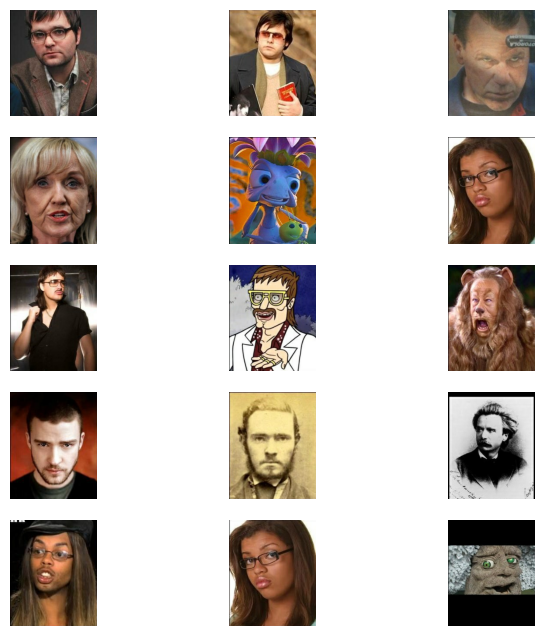

In [10]:
def visualize(anchor, positive, negative_set):
    
    def show(ax, image):
        ax.imshow(image)
        ax.axis('off')
        
    print(anchor[0].shape)


    fig = plt.figure(figsize=(8, 8))
    axs = fig.subplots(5, 3)
        
    for i in range(5):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative_set[i])


visualize(*list(triplets_train.take(1).as_numpy_iterator())[0])


#### Feature extractor network 

We will use ResNet50V2, pretrained on ImageNet, to extract features from the images. All layers preceding `conv5_block1_out` will be frozen, the weights in the remaining layers above will be fine-tuned

In [11]:
input_shape = (245, 200)
feature_dims = 128 # embedding dimensions 

base_cnn = ResNet50V2(weights="imagenet", input_shape=input_shape + (3,), include_top=False) # we do not include the ResNet50 output layer

#base_cnn.summary()

In [12]:
# add some dense layers on top of resnet 
flatten = layers.Flatten() (base_cnn.output)
output = layers.Dense(512, activation='relu')(flatten)
output = layers.BatchNormalization()(output)
output = layers.Dense(256, activation='relu')(flatten)
output = layers.BatchNormalization()(output)
output = layers.Dense(feature_dims, activation='relu')(flatten)

# combine into a new model
feature_extractor = Model(base_cnn.input, output, name="feature_extractor")

# freeze the weights up to layer conv5_block1_out
trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

feature_extractor.summary()

Model: "feature_extractor"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 245, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 251, 206, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 123, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                  

#### Siamese network with custom training loop 

The siamese network takes each of the triplet images, extracts features and outputs the L2-distance between the achor image and positive and negative images. The triplet loss function is used to compute the loss, defined as follows:

$L(A,P,N) = Max(Dist(A,P) - Dist(A,N) + margin, 0.0)$

In [13]:
"""
    A custom layer for computing the distance between extracted features of anchor image and positive/negative images
"""
class DistanceLayer(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        # compute l2-distance between anchor and positive image
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        # compute average l2-distance between anchor and negative images
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)
    

anchor_input = layers.Input(shape=input_shape + (3,), name="anchor")    
positive_input = layers.Input(shape=input_shape + (3,), name="positive")    
negative_input = layers.Input(shape=input_shape + (3,), name="negative")    

distances = DistanceLayer()(feature_extractor(anchor_input), feature_extractor(positive_input), feature_extractor(negative_input))

# define the siamese network model
siamese_network = Model(inputs=[anchor_input, positive_input, negative_input], outputs = distances)

In [14]:
"""
    Siamese network model
"""
class SiameseModel(Model):
    def __init__(self, siamese_network, margin=0.5):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_train = metrics.Mean(name="loss")
        self.accuracy_train = metrics.Mean(name="accuracy")
        self.loss_val = metrics.Mean(name="loss")
        self.accuracy_val = metrics.Mean(name="accuracy")
  

    def call(self, inputs):    
        return self.siamese_network(inputs)
    

    # custom training step
    @tf.function    
    def train_step(self, data):
        # forward propagation on gradient tape
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # compute the loss gradients 
        grads = tape.gradient(loss, self.siamese_network.trainable_weights)

        # backproagation
        self.optimizer.apply_gradients(zip(grads,self.siamese_network.trainable_weights))

        # update the loss and accuracy metrics
        self.loss_train.update_state(loss)
        accuracy = self._compute_accuracy(data)
        self.accuracy_train.update_state(accuracy)

        return {"loss": self.loss_train.result(), "accuracy": self.accuracy_train.result()}
     

    # custom testing step
    @tf.function
    def test_step(self, data):
        # update the loss metric.
        loss = self._compute_loss(data)
        self.loss_val.update_state(loss)
        # update accuracy metric
        accuracy = self._compute_accuracy(data)
        self.accuracy_val.update_state(accuracy)
        

        return {"loss": self.loss_val.result(), "accuracy": self.accuracy_val.result()}


    # define the triplet loss function
    def _compute_loss(self, data):
        # compute distance of anchor from positive and negative images
        ap_distance, an_distance = self.siamese_network(data)
        # compute the triplet loss (we want to minimize ap_distance and maximise an_distance,
        # which is why there's a minus sign infront of an_distance, we also allow for a small margin) 
        loss = ap_distance - an_distance + self.margin   
        # make sure the loss value is non-negative
        loss = tf.maximum(loss, 0.0)
        
        return loss
    

    def _compute_accuracy(self, data):
        # compute distance of anchor from positive and negative images
        ap_distance, an_distance = self.siamese_network(data)
        accuracy = tf.reduce_mean(tf.cast(ap_distance < an_distance, tf.float32))

        return accuracy


    @property
    def metrics(self):
        return [self.loss_tracker, self.accuracy_tracker]
    

# instantiate model object and compile it   
siamese_model = SiameseModel(siamese_network)
opt = optimizers.Adam(learning_rate=0.00001)  # use a small learning rate, because we want to fine-tune the resnet
siamese_model.compile(optimizer=opt)    

In [15]:
"""
    Custom training loop for the siamese network
"""
def train(model, train_dataset, val_dataset, num_epoches=5, checkpoint=None, checkpoint_file_prefix=None):
    num_batches_train = tf.data.experimental.cardinality(train_dataset).numpy()
    num_batches_val = tf.data.experimental.cardinality(val_dataset).numpy()
    for epoch in range(num_epoches):
        start_time = time.time()
        print(f"Epoch {epoch+1}/{num_epoches}")
        
        # training 
        with tqdm(total=num_batches_train, desc='Training') as pbar:
            for data_batch in train_dataset:
                metrics = model.train_step(data_batch)
                pbar.update()
                pbar.set_postfix({'Loss' : metrics['loss'].numpy(), 'Accuracy' : metrics['accuracy'].numpy()})

        # save checpoint every two epochs
        if checkpoint and ((epoch+1)%2 == 0):
            # save model checkpoint
            checkpoint.save(checkpoint_file_prefix) 
            print(f"Saved checkpoint for epoch {epoch+1} at {checkpoint_file_prefix}")

        # validation
        with tqdm(total=num_batches_val, desc='Validation') as pbar:
            for data_batch in val_dataset:
                metrics = model.test_step(data_batch)
                pbar.update()
                pbar.set_postfix({'Loss' : metrics['loss'].numpy(), 'Accuracy' : metrics['accuracy'].numpy()})

        print(f"Total time for epoch: {time.time()-start_time:.2f} sec")
    

#### Training the model

In [16]:
# setup checkpoint manager
checkpoint_dir = './models/project_siamese_training_checkpoints'
checkpoint_file_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=opt, model=siamese_model)

In [17]:
train(siamese_model, triplets_train, triplets_val, num_epoches=6, checkpoint=checkpoint, checkpoint_file_prefix=checkpoint_file_prefix)

Epoch 1/6


Validation: 100%|██████████| 375/375 [01:52<00:00,  3.35it/s, Loss=6.74, Accuracy=0.69] 


Total time for epoch: 640.55 sec
Epoch 2/6


Training: 100%|██████████| 1500/1500 [08:42<00:00,  2.87it/s, Loss=0.662, Accuracy=0.985]


Saved checkpoint for epoch 2 at ./models/project_siamese_training_checkpoints/ckpt


Validation: 100%|██████████| 375/375 [01:48<00:00,  3.45it/s, Loss=6.7, Accuracy=0.7]   


Total time for epoch: 631.75 sec
Epoch 3/6


Validation: 100%|██████████| 375/375 [01:48<00:00,  3.45it/s, Loss=6.42, Accuracy=0.71] 


Total time for epoch: 628.43 sec
Epoch 4/6


Training: 100%|██████████| 1500/1500 [08:40<00:00,  2.88it/s, Loss=0.373, Accuracy=0.993]


Saved checkpoint for epoch 4 at ./models/project_siamese_training_checkpoints/ckpt


Validation: 100%|██████████| 375/375 [01:48<00:00,  3.45it/s, Loss=6.22, Accuracy=0.719]


Total time for epoch: 629.71 sec
Epoch 5/6


Validation: 100%|██████████| 375/375 [01:48<00:00,  3.45it/s, Loss=6.28, Accuracy=0.726]


Total time for epoch: 628.58 sec
Epoch 6/6


Training: 100%|██████████| 1500/1500 [08:40<00:00,  2.88it/s, Loss=0.265, Accuracy=0.995]


Saved checkpoint for epoch 6 at ./models/project_siamese_training_checkpoints/ckpt


Validation: 100%|██████████| 375/375 [01:49<00:00,  3.44it/s, Loss=6.11, Accuracy=0.734]

Total time for epoch: 630.31 sec


##### Generate new batches of triplets with different negative images and fine-tune the network

In [21]:
# training set triplets
(anchor_train, positive_train, negative_train) = generate_triplets_randomly(anchor_images_train, positive_images_train, num_negatives)
# validation set triplets
(anchor_val, positive_val, negative_val) = generate_triplets_randomly(anchor_images_val, positive_images_val, num_negatives)

# create tensorflow datasets
triplets_train = create_tf_dataset_triplets(anchor_train, positive_train, negative_train, batch_size=batch_size)
triplets_val = create_tf_dataset_triplets(anchor_val, positive_val, negative_val, batch_size=batch_size)

In [22]:
# more training with even smaller learning rate
opt.learning_rate.assign(0.000005)

train(siamese_model, triplets_train, triplets_val, num_epoches=4, checkpoint=checkpoint, checkpoint_file_prefix=checkpoint_file_prefix)

Epoch 1/4


Validation: 100%|██████████| 375/375 [01:50<00:00,  3.40it/s, Loss=5.88, Accuracy=0.736]


Total time for epoch: 634.88 sec
Epoch 2/4


Training: 100%|██████████| 1500/1500 [08:47<00:00,  2.84it/s, Loss=0.202, Accuracy=0.996]


Saved checkpoint for epoch 2 at ./models/project_siamese_training_checkpoints/ckpt


Validation: 100%|██████████| 375/375 [01:50<00:00,  3.39it/s, Loss=5.75, Accuracy=0.739]


Total time for epoch: 638.74 sec
Epoch 3/4


Validation: 100%|██████████| 375/375 [01:50<00:00,  3.40it/s, Loss=5.67, Accuracy=0.741]


Total time for epoch: 638.95 sec
Epoch 4/4


Training: 100%|██████████| 1500/1500 [08:47<00:00,  2.84it/s, Loss=0.163, Accuracy=0.997]


Saved checkpoint for epoch 4 at ./models/project_siamese_training_checkpoints/ckpt


Validation: 100%|██████████| 375/375 [01:50<00:00,  3.40it/s, Loss=5.65, Accuracy=0.742]

Total time for epoch: 638.89 sec


In [ ]:
'''
# to restore a saved model from checkpoint
checkpoint = tf.train.Checkpoint(optimizer=opt, model=siamese_model)

if tf.train.latest_checkpoint(checkpoint_dir):
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
    print ('Latest checkpoint restored!!')

'''

#### Evaluating the trained siamese network on the validation dataset

(245, 200, 3)


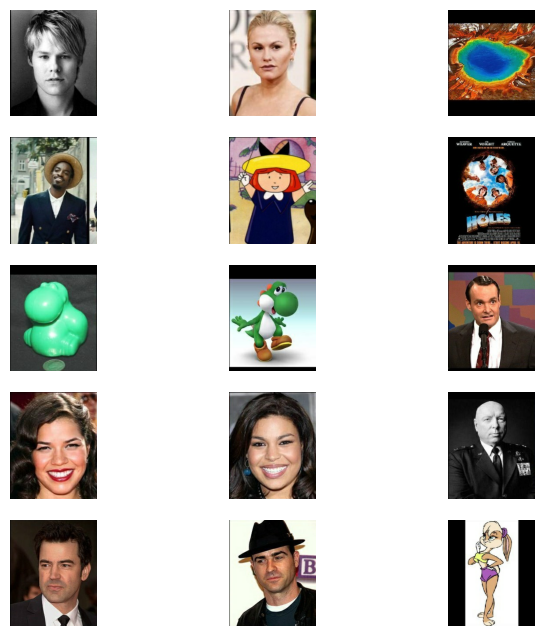

In [24]:
# pick some sample triplets from validation set to visualize
sample = next(iter(triplets_val))
visualize(*sample)

#### Compute the euclidean distance between the anchor and positive/negative images in validation set

In [19]:
def mean_squared_dist(vectors1, vectors2):
    diff = tf.square(vectors1 - vectors2)
    mean_squared_dist = tf.reduce_sum(diff, axis=1)
    return mean_squared_dist

In [25]:
num_correct = 0
for i, (anchor_batch, positive_batch, negative_batch) in enumerate(triplets_val):

    anchor_batch_features, positive_batch_features, negative_batch_features = (feature_extractor(anchor_batch), feature_extractor(positive_batch), feature_extractor(negative_batch))

    positive_distances = mean_squared_dist(anchor_batch_features, positive_batch_features)
    negative_distances = mean_squared_dist(anchor_batch_features, negative_batch_features)
    correct = tf.less(positive_distances, negative_distances)
    num_correct_batch = tf.reduce_sum(tf.cast(correct, tf.float32))
    num_correct += num_correct_batch
    
    print(f"Batch# {i}, batch accuracy = {num_correct_batch/batch_size}")

print(f"Accuracy = {num_correct/(batch_size*i)}")

Batch# 0, batch accuracy = 0.8125
Batch# 1, batch accuracy = 0.6875
Batch# 2, batch accuracy = 0.78125
Batch# 3, batch accuracy = 0.65625
Batch# 4, batch accuracy = 0.75
Batch# 5, batch accuracy = 0.78125
Batch# 6, batch accuracy = 0.75
Batch# 7, batch accuracy = 0.8125
Batch# 8, batch accuracy = 0.8125
Batch# 9, batch accuracy = 0.75
Batch# 10, batch accuracy = 0.8125
Batch# 11, batch accuracy = 0.8125
Batch# 12, batch accuracy = 0.78125
Batch# 13, batch accuracy = 0.875
Batch# 14, batch accuracy = 0.78125
Batch# 15, batch accuracy = 0.84375
Batch# 16, batch accuracy = 0.75
Batch# 17, batch accuracy = 0.625
Batch# 18, batch accuracy = 0.8125
Batch# 19, batch accuracy = 0.71875
Batch# 20, batch accuracy = 0.84375
Batch# 21, batch accuracy = 0.84375
Batch# 22, batch accuracy = 0.875
Batch# 23, batch accuracy = 0.65625
Batch# 24, batch accuracy = 0.8125
Batch# 25, batch accuracy = 0.8125
Batch# 26, batch accuracy = 0.78125
Batch# 27, batch accuracy = 0.75
Batch# 28, batch accuracy = 0.81

#### Load and Prep Test Data

In [28]:
file = open('COMP90086_2023_TLLdataset/test_candidates.csv')
csvreader = csv.reader(file)
header = next(csvreader) # skip header
testset_rows = []
for row in csvreader:
    testset_rows.append(row)
file.close()

def convert_to_path_testset(rows):
    left_img_paths = []
    candidate_img_paths = []
    for row in rows:
        left_img_paths.append('COMP90086_2023_TLLdataset/test/left/' + row[0] + '.jpg')
        candidates = []
        for img in row[1:]: 
            candidates.append('COMP90086_2023_TLLdataset/test/right/' + img + '.jpg')
        candidate_img_paths.append(candidates)
        
    return left_img_paths, candidate_img_paths   


test_left_img_paths, test_candidate_img_paths = convert_to_path_testset(testset_rows)

#### Make predictions: For each left image, compute the euclidean distance to each of the 20 candidates and assign the inverse distance as the similarity score

In [54]:
import sys

def predict_testset(left_img_paths, candidate_img_paths):
    similarity_scores = np.zeros(shape=(len(left_img_paths),20))
    #with tqdm(total=len(left_img_paths), desc='Predicting testset') as pbar:
    for i in range(len(left_img_paths)):
        print(f"Predicting for image #{i}")
        # first preprocess the images, convert to tensors and compute embeddings
        left_embedding = feature_extractor(tf.expand_dims(preprocess_image(left_img_paths[i]),0))
        
        candidate_images = []
        for candidate_path in candidate_img_paths[i]:
            candidate_images.append(preprocess_image(candidate_path))

        # convert bacth of candidates to tensor
        candidates = tf.convert_to_tensor(candidate_images)      
 
        # compute embeddings
        embeddings = feature_extractor(candidates)
 
        # now compute euclidean distances between the left image embedding and candidate image embeddings 
        diff = tf.square(embeddings - left_embedding)
        euclidean_dist = tf.reduce_sum(diff, axis=1).numpy()
        similarity_scores[i,:] = euclidean_dist
      

    # convert distances to similarity score  
    epsilon = min(1.e-15, np.min(similarity_scores)*1.e-6)
    similarity_scores = np.reciprocal(similarity_scores + epsilon)

    # normalize the scores
    #normalized_similarity_scores = (similarity_scores - np.min(similarity_scores)) / (np.max(similarity_scores) - np.min(similarity_scores))
    #pbar.update()

    return similarity_scores


In [55]:
scores = predict_testset(test_left_img_paths, test_candidate_img_paths)

Predicting for image #0
Predicting for image #1
Predicting for image #2
Predicting for image #3
Predicting for image #4
Predicting for image #5
Predicting for image #6
Predicting for image #7
Predicting for image #8
Predicting for image #9
Predicting for image #10
Predicting for image #11
Predicting for image #12
Predicting for image #13
Predicting for image #14
Predicting for image #15
Predicting for image #16
Predicting for image #17
Predicting for image #18
Predicting for image #19
Predicting for image #20
Predicting for image #21
Predicting for image #22
Predicting for image #23
Predicting for image #24
Predicting for image #25
Predicting for image #26
Predicting for image #27
Predicting for image #28
Predicting for image #29
Predicting for image #30
Predicting for image #31
Predicting for image #32
Predicting for image #33
Predicting for image #34
Predicting for image #35
Predicting for image #36
Predicting for image #37
Predicting for image #38
Predicting for image #39
Predicting

In [ ]:
def visualize_testset(left_path, candidate_paths):
    
    # convert to numpy arrays
    left = preprocess_image(left_path).numpy()
    candidates = []
    for candidate_path in candidate_paths:
        candidates.append(preprocess_image(candidate_path).numpy())  
    
    # plot left image
    fig = plt.figure(figsize=(8, 8))
    plt.imshow(left)
    plt.axis('off')
    plt.title("left image")

    # plot candidates        
    for i in range(20):
        plt.subplot(2,10,i)
        plt.imshow(candidates[i])
        plt.axis('off')
        plt.title('Candidate #' + str(i))

    plt.show()